In [37]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [38]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import scipy
from sklearn.ensemble import RandomForestRegressor
import torch.nn as nn
import seaborn as sns

sns.set_theme(style="white")

In [39]:
# Setting variables
N = 100  # Number of samples
D = 10  # Number of features
seed = 1

In [40]:
# To generate samples from Bernoulli Distribution we will use np.random.binomial as If you pass n=1 to the Binomial distribution it is equivalent to the Bernoulli distribution.
# Ref: https://stackoverflow.com/questions/47012474/bernoulli-random-number-generator#:~:text=If%20you%20pass%20n%3D1%20to%20the%20Binomial%20distribution%20it%20is%20equivalent%20to%20the%20Bernoulli%20distribution.

# Generate samples
samples = np.random.binomial(1, 0.5, (N, D))

In [41]:
# Helper for generating feature column name in dataframe.
cols = []
for i in range(1, 11):
    cols.append(f"feature_{i}")

In [42]:
generated_data = pd.DataFrame(samples, columns=cols)

In [43]:
generated_data

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,1,1,0,1,1,0,1,1,1,1
1,0,0,0,0,0,0,0,1,1,1
2,0,0,1,1,0,0,1,0,1,0
3,1,1,0,1,1,1,1,0,1,1
4,0,1,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
95,1,1,0,0,1,0,0,1,0,0
96,1,0,1,0,0,1,0,1,1,0
97,0,1,0,1,1,0,0,1,0,1
98,1,1,0,1,0,0,0,1,1,1


In [44]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.fc1 = nn.Linear(3, 2)
        self.fc2 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

        # Set the weights
        with torch.no_grad():
            self.fc1.weight.fill_(1)
            self.fc2.weight.fill_(1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Create an instance of the network
net321 = SmallNet()

In [45]:
# Test the network with a random samples, choosing first 3 features to be causal features among generated 10 features
input = torch.tensor(generated_data.iloc[:, :3].values, dtype=torch.float32)
output = net321(input)
generated_data.loc[:, "output"] = output.detach().numpy()

In [46]:
generated_data

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,output
0,1,1,0,1,1,0,1,1,1,1,3.436532
1,0,0,0,0,0,0,0,1,1,1,-0.202383
2,0,0,1,1,0,0,1,0,1,0,1.436532
3,1,1,0,1,1,1,1,0,1,1,3.436532
4,0,1,1,0,0,1,1,0,0,0,3.436532
...,...,...,...,...,...,...,...,...,...,...,...
95,1,1,0,0,1,0,0,1,0,0,3.436532
96,1,0,1,0,0,1,0,1,1,0,3.436532
97,0,1,0,1,1,0,0,1,0,1,1.436532
98,1,1,0,1,0,0,0,1,1,1,3.436532


In [47]:
generated_data.shape

(100, 11)

In [48]:
training_data = generated_data.iloc[: int(0.8 * generated_data.shape[0]), :]
test_data = generated_data.iloc[int(0.8 * generated_data.shape[0]) :, :]

In [49]:
training_data.shape

(80, 11)

In [50]:
test_data.shape

(20, 11)

In [51]:
X_train = training_data.iloc[:, :-1]
y_train = training_data.iloc[:, -1:]
X_test = test_data.iloc[:, :-1].reset_index(drop=True)
y_test = test_data.iloc[:, -1:].reset_index(drop=True)

In [52]:
regressor = RandomForestRegressor()

In [53]:
regressor.fit(X_train.values, y_train.values.ravel())

RandomForestRegressor()

In [54]:
y_predicted = regressor.predict(X_test.values)

In [55]:
y_predicted

array([ 1.43653166,  3.43653154,  3.43653154,  5.43653154,  5.43653154,
        3.43653154,  3.41653154,  1.43653166, -0.20238256,  3.43653154,
        3.43653154, -0.20238256, -0.20238256,  1.43653166,  1.43653166,
        3.43653154,  3.43653154,  1.43653166,  3.43653154,  5.43653154])

In [56]:
test_pcc = scipy.stats.pearsonr(y_predicted, y_test.values.ravel())

In [57]:
test_pcc

PearsonRResult(statistic=0.9999968934482757, pvalue=2.558865376289717e-48)

In [58]:
# Calculating shap values for each test example using shap package
import shap

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test.values)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [59]:
shap_values.shape

(20, 10)

In [52]:
shap.summary_plot(shap_values, X_test.values)

IndexError: tuple index out of range

In [230]:
mean_shap_values = (1 / shap_values.shape[0]) * np.abs(shap_values).sum(axis=0)

In [231]:
mean_shap_df = pd.DataFrame(columns=["mean_shap"], index=X_test.columns)
mean_shap_df["mean_shap"] = mean_shap_values

In [232]:
mean_shap_df = mean_shap_df.sort_values(by=["mean_shap"], ascending=True)

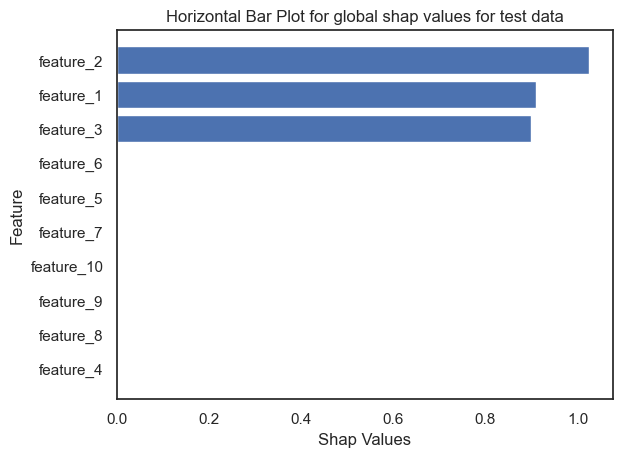

In [233]:
plt.barh(
    range(len(mean_shap_df.index)), mean_shap_df["mean_shap"].values, align="center"
)
plt.yticks(range(len(mean_shap_df.index)), mean_shap_df.index)
plt.xlabel("Shap Values")
plt.ylabel("Feature")
plt.title("Horizontal Bar Plot for global shap values for test data")
plt.show()

In [74]:
class NN10_2_1(nn.Module):
    def __init__(self):
        super(NN10_2_1, self).__init__()
        self.fc1 = nn.Linear(10, 2)
        self.fc2 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

        # Set the weights
        with torch.no_grad():
            self.fc1.weight.fill_(1)
            self.fc2.weight.fill_(1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Create an instance of the network
net10_2_1 = NN10_2_1()

In [75]:
net10_2_1.eval()

NN10_2_1(
  (fc1): Linear(in_features=10, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
)

In [76]:
shap_values[0]

array([ 1.27634117e+00, -1.28852607e+00,  9.12701633e-01,  1.08420217e-19,
        0.00000000e+00, -1.11000165e-02,  0.00000000e+00, -4.16666692e-04,
        1.08420217e-19,  0.00000000e+00])

In [77]:
shap_values.shape

(20, 10)

In [78]:
def calculate_shapley_value(model, instance, feature_names):
    num_features = len(feature_names)
    shapley_values = np.zeros(num_features)
    base_prediction = model.predict([instance])[0]

    for i in range(num_features):
        # Create a copy of the instance with one feature set to 0
        instance_with_feature_removed = instance.copy()
        instance_with_feature_removed[i] = 0

        # Calculate the difference in prediction with the feature removed
        prediction_with_feature_removed = model.predict(
            [instance_with_feature_removed]
        )[0]
        diff = base_prediction - prediction_with_feature_removed

        # Calculate the Shapley value for the feature
        shapley_values[i] = diff / num_features

    return shapley_values

In [79]:
shapley_values_list = []
for i in range(len(X_test)):
    instance = X_test.iloc[i].values
    shapley_values = calculate_shapley_value(regressor, instance, cols)
    shapley_values_list.append(shapley_values)

In [80]:
shapley_values_list[0]

array([ 0.20000001,  0.        ,  0.19600001,  0.        ,  0.        ,
       -0.004     ,  0.        ,  0.        ,  0.        ,  0.        ])

In [81]:
from itertools import chain, combinations
from math import factorial

In [82]:
def subsets_without_feature(features, d):
    """
    Return all subsets of features that do not contain d.
    """
    # Remove the feature d from the list of features
    features = [f for f in features if f != d]

    # Use chain and combinations to generate all possible subsets of the features
    return list(
        chain(*map(lambda x: combinations(features, x), range(0, len(features) + 1)))
    )

In [83]:
x_temp = X_test.copy()

In [84]:
x_temp

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,1,0,1,1,0,1,0,1,1,0
1,0,0,1,0,1,0,0,0,1,1
2,1,0,1,0,0,0,0,0,1,1
3,1,1,0,0,1,1,0,0,0,0
4,0,0,0,1,1,0,1,0,1,0
5,1,1,1,0,0,1,1,1,0,1
6,1,0,0,1,1,1,1,1,0,1
7,0,0,0,0,1,0,0,0,1,1
8,0,0,1,0,1,0,1,0,1,0
9,0,0,0,0,1,0,1,1,1,0


In [85]:
np.random.shuffle(x_temp.iloc[:, 0])

you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


In [130]:
X_test[:, 1]

0     0
1     0
2     0
3     1
4     0
5     1
6     0
7     0
8     0
9     0
10    1
11    0
12    0
13    0
14    0
15    1
16    1
17    1
18    0
19    0
Name: feature_2, dtype: int64

In [118]:
def compute_shapley_value(d, model, X_test):
    F = list(range(X_test.shape[1]))
    phi_d = 0
    for S in subsets_without_feature(F, d)[1:]:
        x_S = X_test.copy()
        x_S_union_d = X_test.copy()
        for j in list(range(10)):
            if j not in list(S):
                # print(x_S.iloc[:, j])
                # np.random.shuffle(x_S.iloc[:, j])
                x_S.iloc[:, j] = 0.5
            if j not in list(S) and j == d:
                x_S_union_d.iloc[:, j] = 0.5
        print(x_S)
        print(x_S_union_d)
        return

        f_S = model.predict(x_S.values)
        f_S_union_d = model.predict(x_S_union_d.values)

        difference = f_S_union_d - f_S
        comb_term = (
            factorial(len(S)) * factorial(len(F) - len(S) - 1) / factorial(len(F))
        )
        phi_d += comb_term * difference

    return phi_d

In [119]:
shap_values = [
    compute_shapley_value(d, regressor, X_test) for d in range(X_test.shape[1])
]

    feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0         0.5          0        0.5        0.5        0.5        0.5   
1         0.5          0        0.5        0.5        0.5        0.5   
2         0.5          0        0.5        0.5        0.5        0.5   
3         0.5          1        0.5        0.5        0.5        0.5   
4         0.5          0        0.5        0.5        0.5        0.5   
5         0.5          1        0.5        0.5        0.5        0.5   
6         0.5          0        0.5        0.5        0.5        0.5   
7         0.5          0        0.5        0.5        0.5        0.5   
8         0.5          0        0.5        0.5        0.5        0.5   
9         0.5          0        0.5        0.5        0.5        0.5   
10        0.5          1        0.5        0.5        0.5        0.5   
11        0.5          0        0.5        0.5        0.5        0.5   
12        0.5          0        0.5        0.5        0.5       

In [111]:
len(shap_values)

10

In [112]:
shap_values[0].shape

(20,)

In [49]:
shapley = np.zeros(shape=(20, 10))

In [50]:
for i in range(len(shap_values)):
    for j in range(shap_values[i].shape[0]):
        shapley[j][i] = shap_values[i][j]

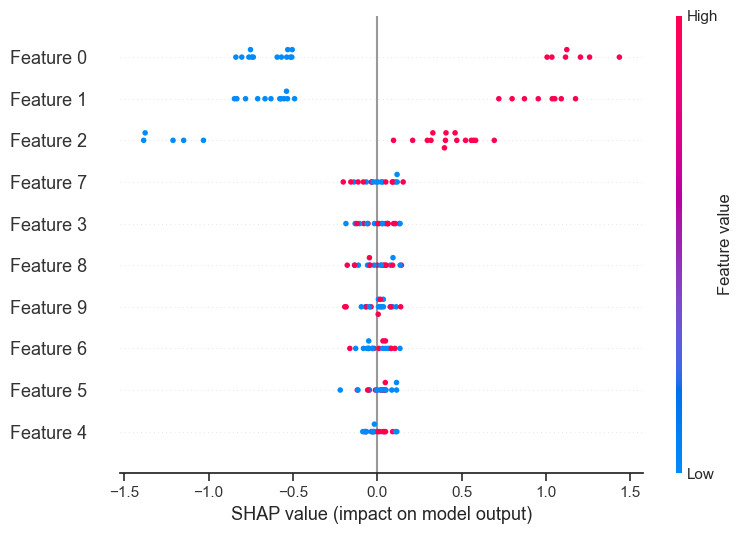

In [51]:
shap.summary_plot(shapley, X_test.values)

In [116]:
num_samples = len(X_test)
num_features = X_test.shape[1]

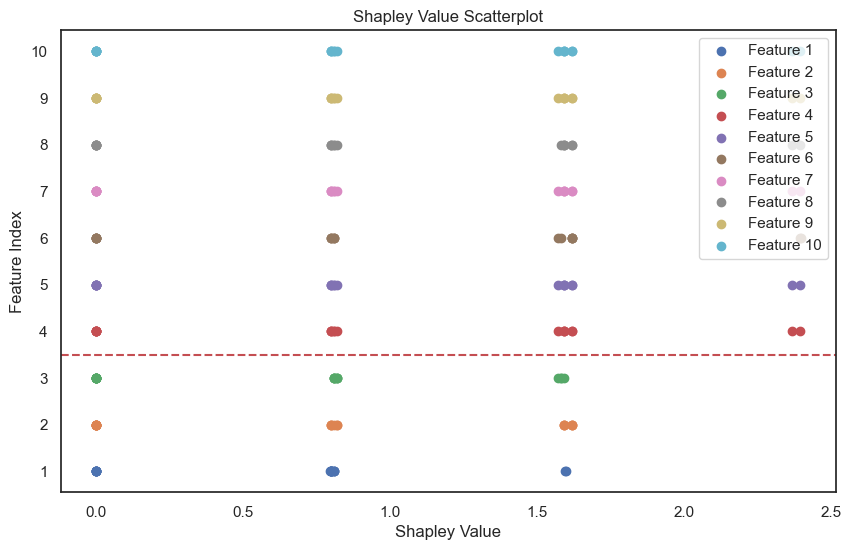

In [117]:
# print("Shapley values using shap implementation:", shap_values)


# Step 4: Plotting Shapley values
def plot_shapley_scatterplot(shap_values, num_samples, num_features):
    plt.figure(figsize=(10, 6))
    for i in range(num_features):
        plt.scatter(shap_values[i], [i] * num_samples, label=f"Feature {i+1}")

    plt.axhline(
        y=2.5, color="r", linestyle="--"
    )  # This line denotes the separation between the causal features (first 3) and the rest.
    plt.title("Shapley Value Scatterplot")
    plt.xlabel("Shapley Value")
    plt.ylabel("Feature Index")
    plt.yticks(range(num_features), range(1, num_features + 1))
    plt.legend(loc="upper right")
    plt.show()


plot_shapley_scatterplot(shap_values, num_samples, num_features)


def plot_global_shapley_attributions(shap_values, num_features):
    plt.figure(figsize=(10, 6))
    mean_shapley_values = np.mean(np.abs(shap_values), axis=0)
    plt.bar(range(1, num_features + 1), mean_shapley_values)
    plt.title("Global Feature Attributions (Mean Shapley Values)")
    plt.xlabel("Feature Index")
    plt.ylabel("Mean Absolute Shapley Value")
    plt.xticks(range(1, num_features + 1))
    plt.show()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates a

Pearson Correlation Coefficient: 0.9999492349166653
Shapley values using the shap library: [-8.70989644e-01 -1.01355406e+00  8.83353738e-01  0.00000000e+00
  0.00000000e+00 -8.21874902e-04  0.00000000e+00  1.93749977e-04
  8.81614250e-03  0.00000000e+00]


you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave cor

Shapley values using shap implementation: [-0.70905991  1.17651306  1.03828731 -0.53797326  1.0533597  -0.5695572
 -0.55192651 -0.57801693 -0.66550791 -0.78092552 -0.53213968  0.80019622
  0.87343506  0.72134703  0.95531217 -0.83264056 -0.84696796 -0.49023326
  1.09187914 -0.63040502]


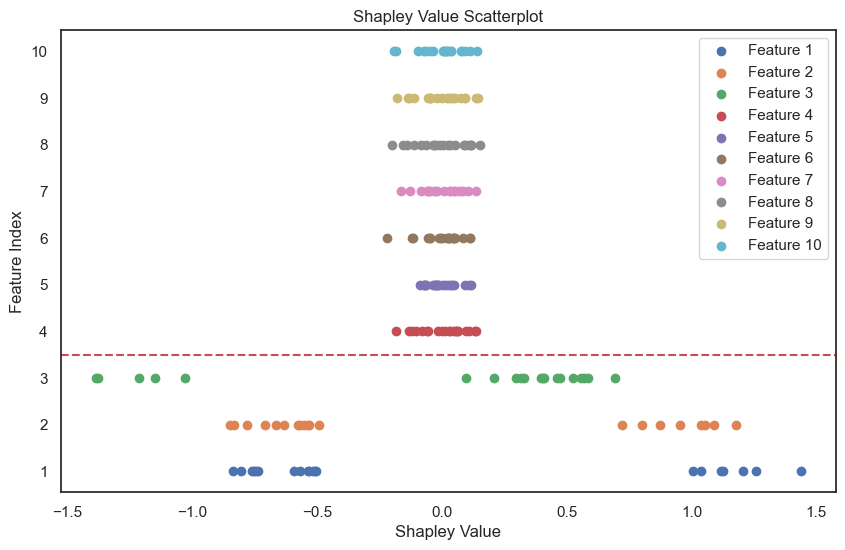

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (20,).

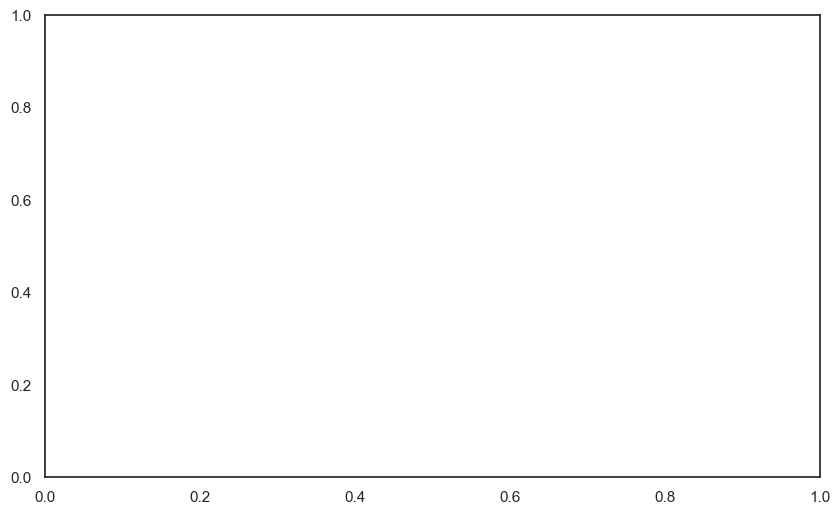

In [48]:
# Question 2 : Shapley Values

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
from itertools import chain, combinations
from math import factorial
import shap
import matplotlib.pyplot as plt


rf_regressor = RandomForestRegressor(
    random_state=42
)  # Define the random forest regressor
rf_regressor.fit(X_train, y_train)

# Step 3: Make predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Step 4: Calculate Pearson correlation coefficient
corr_coefficient, _ = pearsonr(y_test.values.ravel(), y_pred)

# Print the correlation coefficient
print("Pearson Correlation Coefficient:", corr_coefficient)

# Step 3: Calculate Shapley values for each feature

# Compute Shapley values
explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer.shap_values(X_test)

# # Print Shapley values for the first test instance
print("Shapley values using the shap library:", shap_values[0])

num_samples = len(X_test)
num_features = X_test.shape[1]
shapley_values = np.zeros(num_features)


def subsets_without_feature(features, d):
    """
    Return all subsets of features that do not contain d.
    """
    # Remove the feature d from the list of features
    features = [f for f in features if f != d]

    # Use chain and combinations to generate all possible subsets of the features
    return list(
        chain(*map(lambda x: combinations(features, x), range(0, len(features) + 1)))
    )


def compute_shapley_value(d, model, X_test):
    F = list(range(X_test.shape[1]))
    phi_d = 0
    for S in subsets_without_feature(F, d)[1:]:
        x_S = X_test.copy()
        x_S_union_d = X_test.copy()

        for j in list(range(10)):
            if j == d:
                np.random.shuffle(x_S.iloc[:, j])
            elif j not in list(S):
                np.random.shuffle(x_S.iloc[:, j])
                np.random.shuffle(x_S_union_d.iloc[:, j])
                # np.random.shuffle(x_S.iloc[:, j])

                # np.random.shuffle(x_S_union_d.iloc[:, j])
        f_S = model.predict(x_S)
        f_S_union_d = model.predict(x_S_union_d)

        difference = f_S_union_d - f_S
        comb_term = (
            factorial(len(S)) * factorial(len(F) - len(S) - 1) / factorial(len(F))
        )
        phi_d += comb_term * difference

    return phi_d


shap_values = [
    compute_shapley_value(d, rf_regressor, X_test) for d in range(X_test.shape[1])
]

print("Shapley values using shap implementation:", shap_values[1])


# Step 4: Plotting Shapley values
def plot_shapley_scatterplot(shap_values, num_samples, num_features):
    plt.figure(figsize=(10, 6))
    for i in range(num_features):
        plt.scatter(shap_values[i], [i] * num_samples, label=f"Feature {i+1}")

    plt.axhline(
        y=2.5, color="r", linestyle="--"
    )  # This line denotes the separation between the causal features (first 3) and the rest.
    plt.title("Shapley Value Scatterplot")
    plt.xlabel("Shapley Value")
    plt.ylabel("Feature Index")
    plt.yticks(range(num_features), range(1, num_features + 1))
    plt.legend(loc="upper right")
    plt.show()


plot_shapley_scatterplot(shap_values, num_samples, num_features)


def plot_global_shapley_attributions(shap_values, num_features):
    plt.figure(figsize=(10, 6))
    mean_shapley_values = np.mean(np.abs(shap_values), axis=0)
    plt.bar(range(1, num_features + 1), mean_shapley_values)
    plt.title("Global Feature Attributions (Mean Shapley Values)")
    plt.xlabel("Feature Index")
    plt.ylabel("Mean Absolute Shapley Value")
    plt.xticks(range(1, num_features + 1))
    plt.show()


plot_global_shapley_attributions(shap_values, num_features)

Input features:
 [[1 1 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0

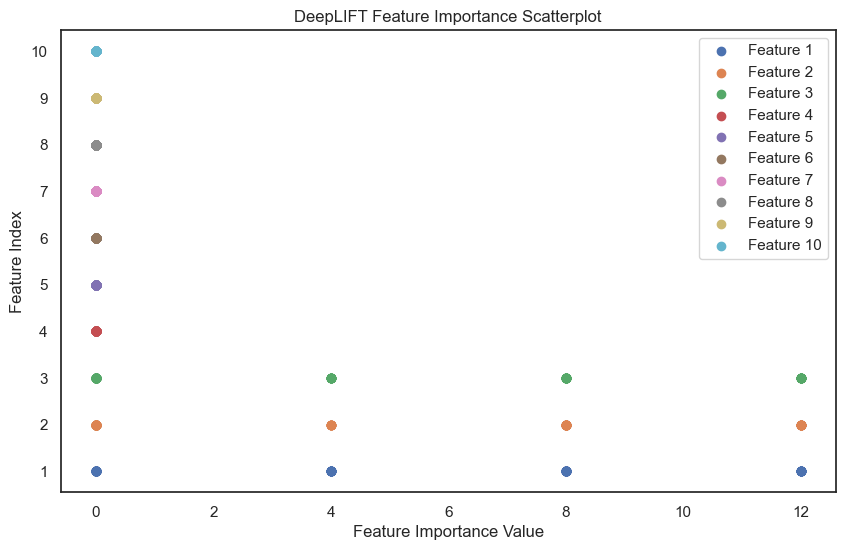

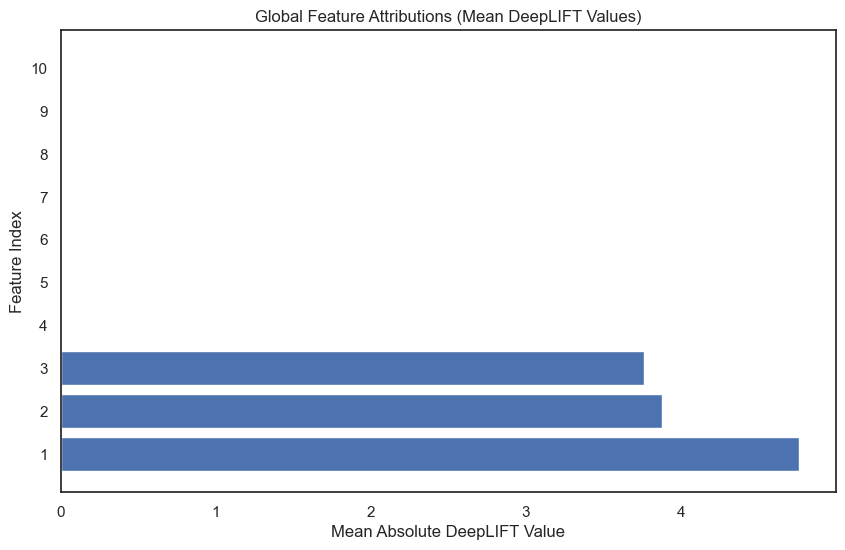

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Define the simple 10-2-1 neural network
def simple_nn(X, w1, w2):
    # Forward pass
    hidden = np.maximum(0, np.dot(X, w1))  # ReLU activation
    output = np.dot(hidden, w2)
    return hidden, output

# DeepLIFT: Linear and Rescale Rule
def compute_multipliers(input_data, w1, w2):
    # Using all-zero input as reference
    reference_input = np.zeros_like(input_data)
    
    # Compute activations with input and reference
    _, output_with_input = simple_nn(input_data, w1, w2)
    _, output_with_reference = simple_nn(reference_input, w1, w2)

    # Compute the difference from reference activations
    delta_output = output_with_input - output_with_reference
    delta_input = input_data - reference_input

    # Compute multiplier using the Rescale rule (∆y/∆x)
    epsilon = 1e-7
    m_i_h =  (delta_output/(delta_input+epsilon)) 
    #compute multiplier using the linear rule
    m_h_y = w2

    multiplier = m_i_h * m_h_y
    
    
    return multiplier, delta_input

# Backpropagation of multipliers to compute feature importance
def deep_lift_feature_importance(X, w1, w2):
    feature_importances = []
    
    for input_sample in X:
        multipliers, delta_input = compute_multipliers(input_sample, w1, w2)
        # Compute feature importance: C = m∆x/∆y * ∆x
        feature_importance =  np.sum(multipliers * delta_input, axis=0)
        feature_importances.append(feature_importance)
    
    return np.array(feature_importances)

# Test the implementation
N = 100  # Number of samples
num_features = 10  # Number of input features

# Simulate input features
input_features = np.random.binomial(1, 0.5, (N, num_features))

input_features[:, 3:10] = 0 # Set the first sample to be the same as the ground truth
print("Input features:\n", input_features)

# Set the weights to be the same as the ground truth
w1 = np.ones((10, 2))
w2 = np.ones((2, 1))

# Compute feature importance for the test data
feature_importances = deep_lift_feature_importance(input_features, w1, w2)
# Plotting the scatter plot for individual test examples
def plot_scatterplot(feature_importances):
    plt.figure(figsize=(10,6))
    for i in range(feature_importances.shape[1]):
        plt.scatter(feature_importances[:, i], [i] * feature_importances.shape[0], label=f'Feature {i+1}') # Plot the DeepLIFT contributions for each feature
    plt.title("DeepLIFT Feature Importance Scatterplot")
    plt.xlabel("Feature Importance Value")
    plt.ylabel("Feature Index")
    plt.yticks(range(feature_importances.shape[1]), range(1, feature_importances.shape[1] + 1)) 
    plt.legend()
    plt.show()

plot_scatterplot(feature_importances)

def plot_global_feature_attributions(feature_importances):
    plt.figure(figsize=(10,6))
    mean_contributions = np.mean(np.abs(feature_importances), axis=0) # Calculate the mean absolute DeepLIFT value for each feature
    plt.barh(range(1, feature_importances.shape[1] + 1), mean_contributions) # Plot the mean absolute DeepLIFT values for each feature
    plt.title("Global Feature Attributions (Mean DeepLIFT Values)")
    plt.ylabel("Feature Index")
    plt.xlabel("Mean Absolute DeepLIFT Value")
    plt.yticks(range(1, feature_importances.shape[1] + 1))
    plt.show()

plot_global_feature_attributions(feature_importances)

In [47]:
def NN1021(X, w1, w2):
    h_1 = np.dot(X, w1)
    h_2 = np.maximum(0, h_1)
    y = np.dot(h_2, w2)
    return h_1, h_2, y
    

In [51]:
w1 = np.ones((10, 2))
w2 = np.ones((2, 1))
X = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
ref_X = np.zeros((10, ))
h_1_ref, h_2_ref, y_ref = NN1021(ref_X, w1, w2)
h_1_pred, h_2_pred, y_pred = NN1021(X, w1, w2)

In [53]:
print(h_1_ref)
print(h_2_ref)
print(y_ref)

[0. 0.]
[0. 0.]
[0.]


In [54]:
print(h_1_pred, h_2_pred, y_pred)

[2. 2.] [2. 2.] [4.]


In [56]:
delta_h2 = h_2_pred - h_2_ref

In [58]:
w1[0] * delta_h2 * 

array([[2., 2.],
       [2., 2.]])

In [59]:
w2

array([[1.],
       [1.]])

In [60]:
delta_h2

array([2., 2.])

In [64]:
import numpy as np

def simple_nn(X, w1, w2):
    # Forward pass
    h1 = np.dot(X, w1)
    h2 = np.maximum(0, h2)  # ReLU activation
    y = np.dot(h2, w2)
    return h1, h2, y

def deeplift(X, w1, w2, reference):
    # Forward pass
    h1, h2, y = simple_nn(X, w1, w2)
    reference_h1, reference_h2, reference_output = simple_nn(reference, w1, w2)
    # Compute the differences
    delta_h1 = h1 - reference_h1 
    delta_h2 = h2 - reference_h2



    

    return scores

# Example usage:
X = np.array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])
w1 = np.ones((10, 2))
w2 = np.ones((2,1))
reference = np.zeros((10,))

scores = deeplift(X, w1, w2, reference)
print(scores)

[[2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]]
[[4.]
 [4.]]


ValueError: operands could not be broadcast together with shapes (10,2) (2,1) 

In [65]:
import numpy as np

def simple_nn(X, w1, w2):
    # Forward pass
    h1 = np.dot(X, w1)
    h2 = np.maximum(0, h1)  # ReLU activation
    output = np.dot(h2, w2)
    return h1, h2, output

def calculate_delta_x_delta_y(X, w1, w2, reference):
    # Forward pass
    h1, h2, output = simple_nn(X, w1, w2)
    reference_h1, reference_h2, reference_output = simple_nn(reference, w1, w2)
    
    delta_input =  X - reference
    # For calculation of multipliers
    # h1 = np.dot(X, w1) multiplier will be calculated according to the Linear Rule
    m_delta_i_delta_h1 = w1
    # h2 = np.maximum(0, h1) multiplier will be calculated according to the Rescale Rule
    # For avoiding division by zero 
    small_delta = 0.00000001
    m_delta_h1_delta_h2 = (h2 - reference_h2) / ((h1 - reference_h1)+ small_delta)
    # output = np.dot(h2, w2) multiplier will be calculated according to the Linear Rule
    m_delta_h2_delta_y = w2
    return (m_delta_i_delta_h1 * m_delta_h1_delta_h2 * m_delta_h2_delta_y).sum(axis=1)

def deepLIFT(dataset):
    reference_input = np.zeros((10,))
    w1 = np.ones((10, 2))
    w2 = np.ones((2,))
    attributions = []
    for i in range(dataset.shape[0]):
        input_x = dataset[i]
        # Setting non causal features to 0.
        input_x[3:] = 0
        delta_i = input_x - reference_input
        m_delta_i_delta_y = calculate_attributions(input_x, w1, w2, reference_input)
        attribution_delta_i_delta_y = np.multiply(delta_i, m_delta_i_delta_y)
        attributions.append(attribution_delta_i_delta_y)
    return np.array(attributions)
    

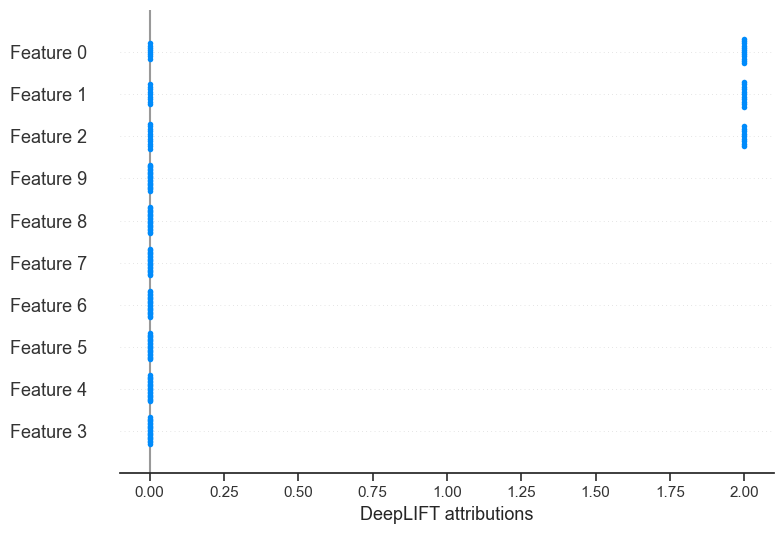

In [149]:
deeplift_attributions = deepLIFT(X_test.values)
shap.summary_plot(deeplift_attributions, show=False)
plt.xlabel("DeepLIFT attributions")
plt.show()  # Show the plot


In [125]:
deeplift_mean_attribution_values = (1 / deeplift_attributions.shape[0]) * np.abs(
    deeplift_attributions
).sum(axis=0)

In [126]:
deeplift_mean_attribution_df = pd.DataFrame(
    columns=["mean_attributions"], index=test_data.columns[:-1]
)
deeplift_mean_attribution_df["mean_attributions"] = deeplift_mean_attribution_values

In [127]:
deeplift_mean_attribution_df = deeplift_mean_attribution_df.sort_values(
    by=["mean_attributions"], ascending=True
)

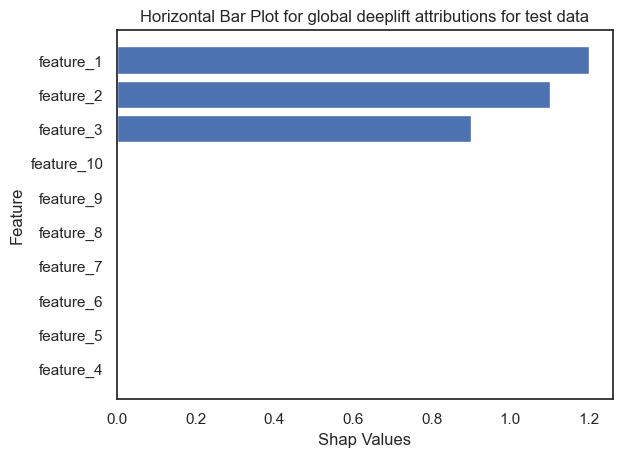

In [148]:
plt.barh(
    range(len(deeplift_mean_attribution_df.index)),
    deeplift_mean_attribution_df["mean_attributions"].values,
    align="center",
)
plt.yticks(range(len(deeplift_mean_attribution_df.index)), deeplift_mean_attribution_df.index)
plt.xlabel("Shap Values")
plt.ylabel("Feature")
plt.title("Horizontal Bar Plot for global deeplift attributions for test data")
plt.show()